In [41]:

from pymatgen.analysis.elasticity import ElasticTensor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pymatgen.ext.matproj import MPRester
from pymatgen.core import Lattice, Structure
from scipy.integrate import quad
from lmapr1492 import plot_brillouin_zone, get_plot_bs, get_plot_dos, get_plot_bs_and_dos, get_branch_wavevectors
from scipy.optimize import curve_fit

In [42]:
mp_key = "jkj1S0TLmQtlvQmGDoUQvq5XQzLfKlCF"
mp_id = "mp-14437"

In [43]:
with MPRester(mp_key) as m:
    prim_struc = m.get_structure_by_material_id(mp_id)
    ph_dos = m.get_phonon_dos_by_material_id(mp_id)
fig_ph_dos = get_plot_dos(ph_dos)
fig_ph_dos.show()

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving PhononBSDOSDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Calcule des températures de Debye  et D'Einstein  en minimisant l'erreur aux sense des moindres carré grâce à la fonction curve_fit. Selon Einstein,les atomes sont des oscillateurs harmoniques ayant tous la même fréquences ceux si peuvent vibre dans les 3 dimensions de l'espace ce qui donne comme formule $C_V(T) = 3*R*(\frac{\theta_E}{T})²*\frac{e^{(\frac{\theta_E}{T})}}{e^{(\frac{\theta_E}{T})}-1}²$
Tandis que Debye, quantifie les vibrations sous forme de phonons (quanta de vibration du réseau ) qui se propage sous formes d'onde.Dans le modèle de Debye, on suppose qu'il existe une fréquence maximale $ν_D$​, au-delà de laquelle il n'y a pas de phonons, ce qui est caractérisé par la température de Debye $θ_D​$. Cette fréquence limite est déterminée par la vitesse de propagation des ondes dans le matériau et la densité des atomes dans le réseau cristallin.La capacité calorifique dans le modèle de Debye est calculée comme
$C_V(T) = 9*N*k_B*(\frac{T}{\theta_E})³* \displaystyle  \int_{0}^{\frac{\theta_E}{T}} \frac{x⁴*e^x}{(e^x-1)²} \,\mathrm{d}x$.


In [44]:
R = 8.314 
Temp = np.linspace(5, 1000, 500)
N= len(prim_struc)

donnee_cv =[]
def debye_integrand(x):
    return (x**4 * np.exp(x)) / ((np.exp(x) - 1)**2)

def cv_debye(T, theta_D):

    cv_values = []
    for Ti in T:
        integral, _ = quad(debye_integrand, 0.0000001, theta_D / Ti)
        cv_values.append(3 * (Ti / theta_D)**3 * integral)
    return np.array(cv_values)


def einstein_model(T, theta_E):
    return (theta_E / T)**2 * np.exp(theta_E / T) / ((np.exp(theta_E / T) - 1)**2)

In [45]:
for i in range(len(Temp)):
    donnee_cv.append(ph_dos.cv(Temp[i])/(3*N*R))

In [46]:
optimal, _ = curve_fit(einstein_model, Temp, donnee_cv)
print("Température d'Einstein[K]: ", optimal[0])
optimal2,_ = curve_fit(cv_debye, Temp, donnee_cv)
print("Température de Debye  [K]: ", optimal2[0])

Température d'Einstein[K]:  329.40667960843155
Température de Debye  [K]:  446.6956418483003


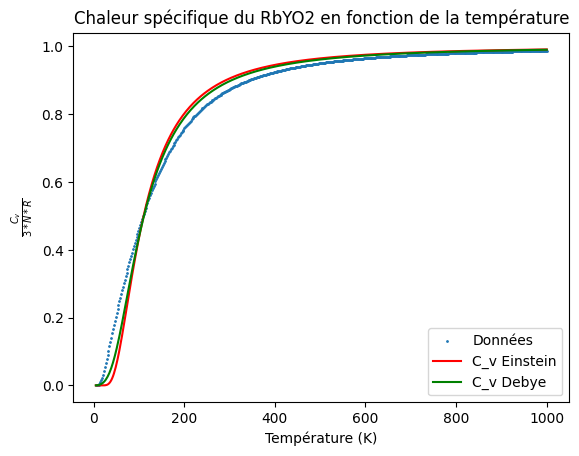

In [47]:
plt.scatter(Temp, donnee_cv, label= 'Données', s = 1)
plt.xlabel('Température (K)')
plt.ylabel(r'$\frac{C_v}{3*N*R}$')
plt.title('Chaleur spécifique du RbYO2 en fonction de la température')

#Chaleur spécifique selon Einstein
cv = einstein_model(Temp, optimal[0])
plt.plot(Temp, cv, label = "C_v Einstein", color = 'r')

#Chaleur spécifique selon Debye
cv = cv_debye(Temp, optimal2[0])
plt.plot(Temp, cv, label = 'C_v Debye', color= 'g')
plt.legend()
plt.show()


Fréquence de vibration naturelle du cristal:  6.863721519680884 THz
Fréquence de Debye:  9.307626953243378 THz


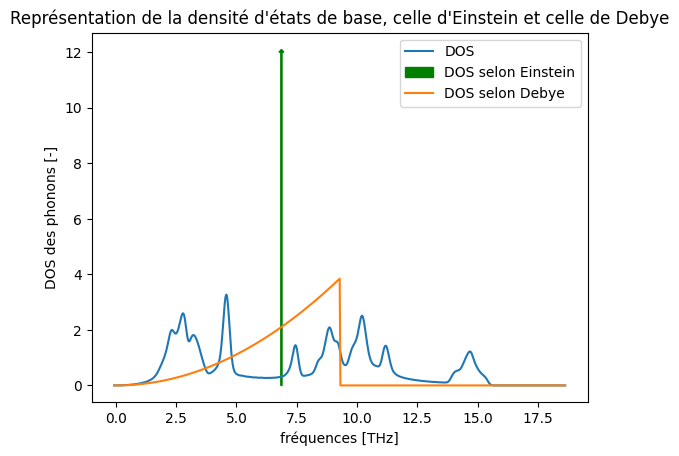

In [57]:
kb= 1.380649 * 10**(-23)
h = 6.62607015*10**(-34)
delta_P =  kb* optimal[0] / h* 10**-12
print("Fréquence de vibration naturelle du cristal: ", delta_P , "THz")

# Obtenir les fréquences et la densité d'états
frequencies = ph_dos.frequencies
density = ph_dos.densities


plt.plot(frequencies, density, label="DOS")

plt.arrow(delta_P, 0, 0, 3*N, width=0.05, head_width=0.2, head_length=0.1, fc='green', ec='green', label = "DOS selon Einstein")

V = prim_struc.volume
F_D = kb*optimal2[0] / h*10**(-12)
print("Fréquence de Debye: ", F_D, "THz")
q_D = (6*np.pi**2/V)**(1/3)
dens_D = np.zeros(len(frequencies))
for i in range(len(frequencies)):
    if frequencies[i] < F_D:
        dens_D[i] = (3*N*V*(frequencies[i])**2*q_D**3)/(2*(np.pi**2)*F_D**3)
    else:
        dens_D[i] = 0
plt.plot(frequencies, dens_D, label = "DOS selon Debye")
plt.title("Représentation de la densité d'états,d'Einstein ,de Debye et la vraie")
plt.ylabel('DOS des phonons [-]')
plt.xlabel('fréquences [THz]')
plt.xlim(0, 16)
plt.legend()
plt.show()
